In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

batch_size = 4

train_set = torchvision.datasets.CIFAR10(root='./data',train=True, download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data',train=False, download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [2]:
import torch.nn as nn
import torchvision.models as models
#VGG16
pre_vgg = models.vgg19_bn(pretrained=True)
pre_vgg

/home/eslab/anaconda3/envs/kkh38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eslab/anaconda3/envs/kkh38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [144]:
class VGG_CAM(nn.Module):
    def __init__(self, pre_vgg):
        super().__init__()
        self.features = nn.Sequential( # 여기를 굳이 그냥 models.vgg19_bn(pretrained = True)를 넣어주지 않는 것에는 이유가 있나..... 아 feature extraction 밖에 필요가 없구나....
            # *list(pre_vgg.features.children())
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding = 1),# 4 x 6 x 32 x 32
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False),
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(True),
            nn.Conv2d(128, 128, 3, 1, 1),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(128, 10),
        )
    def forward(self, x):
        feat_map = self.features(x)
        feature_size = feat_map.shape[2] * feat_map.shape[3]
        out = feat_map.mean(dim=(2, 3))  # out = torch.einsum('ijkl -> ij', out) / feature_size
        out = self.linear(out)
        return out, feat_map


In [145]:
model = VGG_CAM(pre_vgg)
sample_data, sample_label = next(iter(train_loader))
out, feat_map = model(sample_data)
out.shape, feat_map.shape

(torch.Size([4, 10]), torch.Size([4, 128, 8, 8]))

In [146]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [147]:
model = model.to(device)

In [350]:
from tqdm import tqdm
epochs = 20
for ep in range(epochs):
    progressbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}", unit="batch")
    losses = 0
    for i, (data, label) in enumerate(progressbar):
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        out, _ = model(data)
        loss = criterion(out, label)
        losses += loss.item()
        loss.backward()
        optimizer.step()
    print(losses/(len(train_loader) * batch_size))

Epoch 1/5: 100%|██████████| 12500/12500 [01:47<00:00, 116.18batch/s]


0.13002205510883189


Epoch 2/5: 100%|██████████| 12500/12500 [01:45<00:00, 118.07batch/s]


0.123321840042439


Epoch 3/5: 100%|██████████| 12500/12500 [01:46<00:00, 117.29batch/s]


0.11739129702241614


Epoch 4/5: 100%|██████████| 12500/12500 [01:46<00:00, 116.83batch/s]


0.110413071324899


Epoch 5/5: 100%|██████████| 12500/12500 [01:48<00:00, 115.02batch/s]

0.10454174318900655


In [351]:
progressbar = tqdm(test_loader, desc=f"Epoch {ep+1}/{epochs}", unit="batch")
losses = 0
correct = 0

with torch.no_grad():
    for i, (data, label) in enumerate(progressbar):
        # optimizer.zero_grad()
        
        data = data.to(device)
        label = label.to(device)
        out,_ = model(data)
        loss = criterion(out, label)
        losses += loss.item()
        _, predicted = torch.max(out, 1)
        
        # Count correct predictions
        correct += (predicted == label).sum().item()
        # loss.backward()
        # optimizer.step()
print(losses/(len(train_loader) * batch_size), "correct : ", correct,"/",(len(test_loader)*batch_size))

Epoch 5/5: 100%|██████████| 2500/2500 [00:06<00:00, 397.14batch/s]

0.04614313850042336 correct :  7199 / 10000


In [469]:
sample_data, sample_label = next(iter(train_loader))
out, feat_map = model(sample_data.to(device))

# out.shape, feat_map.shape

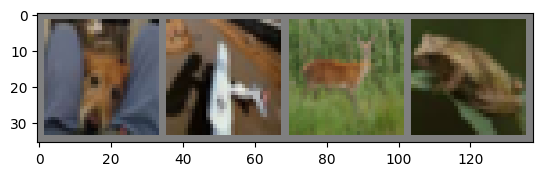

dog   plane deer  frog 


torch.Size([4, 3, 32, 32])

In [470]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

images.shape

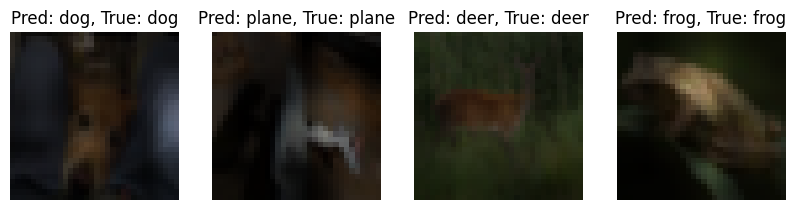

In [471]:
images = images.to(device)
labels = labels.to(device)
out, feat_map = model(images)
ans = 0
cam_map = F.interpolate(torch.sum(model.linear[0].weight[labels].unsqueeze(-1).unsqueeze(-1) * feat_map, dim = 1).unsqueeze(1), size=(32, 32), mode = 'bilinear', align_corners=False)
cam_map = cam_map - cam_map.min()  # Shift to 0
cam_map = cam_map / cam_map.max()  # Scale to [0, 1]

scaled_images = images
scaled_images = scaled_images - scaled_images.min()  # Shift to 0
scaled_images = scaled_images / scaled_images.max()  # Scale to [0, 1]
scaled_images = scaled_images * 255.0          # Scale to [0, 255]

cam_map = (cam_map * scaled_images).cpu().detach().numpy().astype(np.uint8)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))

# Loop over the indices 1, 2, 3, 4 to display each

_, predicted = torch.max(out, 1)


for p in range(4):
    ax = axes[p]  # Calculate subplot position
    ax.imshow(np.transpose(cam_map[p], (1, 2, 0)))  # Display image
    ax.set_title(f'Pred: {classes[predicted[p]]}, True: {classes[labels[p]]}')
    ax.axis('off')  # Turn off axis for clarity

plt.show()
# p = 1
# plt.imshow(np.transpose((cam_map[p]), (1, 2, 0)))